# TabKAN


## Imports & Data Loading

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from scipy.stats import ks_2samp
from imblearn.over_sampling import RandomOverSampler

from tabkan import ChebyshevKAN

# Configuration
RANDOM_STATE = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

# Set seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

✅ Using device: cuda


## Load and Clean Data

In [2]:
# --- LOAD DATA ---
DATA_DIR = os.path.join(os.getcwd(), 'data')

def load_first_csv(data_dir):
    if not os.path.exists(data_dir):
        # Create dummy data if folder missing (Safety fallback)
        print("⚠️ No data folder found. Generating DUMMY data for testing...")
        from sklearn.datasets import make_classification
        X, y = make_classification(n_samples=1000, n_features=10, random_state=42)
        df = pd.DataFrame(X, columns=[f'col_{i}' for i in range(10)])
        df['Churn'] = y
        df['TotalCharges'] = np.random.uniform(10, 1000, 1000)
        return df

    csvs = glob.glob(os.path.join(data_dir, '*.csv'))
    if not csvs:
        raise FileNotFoundError("No CSV files found in /data")
    
    print(f"📂 Loading: {csvs[0]}")
    return pd.read_csv(csvs[0])

df_raw = load_first_csv(DATA_DIR)

# --- CLEANING ---
df = df_raw.copy()
target_col = "Churn"

# 1. Fix Target to 0/1
if df[target_col].dtype == 'O':
    df[target_col] = df[target_col].str.lower().map(
        {'yes':1,'sim':1,'true':1,'no':0,'nao':0,'false':0}
    ).fillna(0)

# 2. Fix TotalCharges (Object -> Float)
if 'TotalCharges' in df.columns and df['TotalCharges'].dtype == 'O':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 3. Drop NaNs
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

# 4. Split X / y
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

print(f"✅ Data Loaded. Shape: {df.shape}")

📂 Loading: /home/pcgr/Code/churn-predict/data/customer_churn_telecom_services.csv
✅ Data Loaded. Shape: (7032, 20)


## Pre Processamento
KANs fail if inputs are large integers. We must use StandardScaler to normalize everything to roughly -1 to 1.

In [3]:
# --- PREPROCESSING ---
# KANs need numbers. We OneHotEncode categories and Scale numbers.
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

# Define Transformation Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

# Apply Transformations
X_processed = preprocessor.fit_transform(X)
y_processed = y.values

# Split Train/Val/Test (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed, y_processed, test_size=0.4, random_state=RANDOM_STATE, stratify=y_processed
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

# Oversample Training Data Only
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# --- CONVERT TO PYTORCH TENSORS ---
X_train_t = torch.FloatTensor(X_train_bal).to(DEVICE)
y_train_t = torch.FloatTensor(y_train_bal).unsqueeze(1).to(DEVICE)

X_val_t = torch.FloatTensor(X_val).to(DEVICE)
y_val_t = torch.FloatTensor(y_val).unsqueeze(1).to(DEVICE)

X_test_t = torch.FloatTensor(X_test).to(DEVICE)
y_test_t = torch.FloatTensor(y_test).unsqueeze(1).to(DEVICE)

print(f"✅ Data converted to Tensors.")
print(f"   Input Features: {X_train_t.shape[1]}")
print(f"   Train Size: {X_train_t.shape[0]}")

✅ Data converted to Tensors.
   Input Features: 45
   Train Size: 6196


## Arquitetura do Modelo


In [6]:
import torch
import torch.nn as nn
# Certifique-se de importar a 'Layer' e não o modelo completo
try:
    from tabkan.chebyshev import ChebyKANLayer
except ImportError:
    # Fallback caso a estrutura da library seja diferente, baseado no seu traceback
    from tabkan.chebyshev.model import ChebyKANLayer

class ChurnKAN(nn.Module):
    def __init__(self, input_dim):
        super(ChurnKAN, self).__init__()
        
        # --- CORREÇÃO AQUI ---
        # Usamos ChebyKANLayer(input, output, degree)
        self.layer1 = ChebyKANLayer(input_dim, 32, degree=4)
        self.ln1 = nn.LayerNorm(32)
        
        # Assumindo que você quer uma saída final de 1 neurônio (Binary Classification)
        # Se sua rede tinha mais camadas, adicione-as aqui da mesma forma
        self.layer2 = ChebyKANLayer(32, 1, degree=4) 
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.ln1(x)
        x = torch.tanh(x) # KANs costumam performar bem com tanh ou silu no meio
        x = self.layer2(x)
        return x

In [7]:
# Initialize Model
input_dim = X_train_t.shape[1]

# Agora isso deve funcionar sem o erro de TypeError
model = ChurnKAN(input_dim).to(DEVICE)

# Optimizer & Loss
criterion = nn.BCEWithLogitsLoss()
# Adicionei o otimizador caso precise rodar logo em seguida
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

print("Modelo inicializado com sucesso:")
print(model)

Modelo inicializado com sucesso:
ChurnKAN(
  (layer1): ChebyKANLayer()
  (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (layer2): ChebyKANLayer()
)


## Training

In [8]:
# Configurações de Treino
epochs = 1000  # Ajuste conforme necessário
print_every = 100
train_losses = []

print("Iniciando treinamento...")

for epoch in range(epochs):
    model.train()
    
    # 1. Forward pass
    optimizer.zero_grad()
    outputs = model(X_train_t)
    
    # Ajuste de dimensão do target se necessário (de [N] para [N, 1])
    # O BCEWithLogitsLoss espera que output e target tenham o mesmo shape
    loss = criterion(outputs, y_train_t.view(-1, 1))
    
    # 2. Backward pass e Otimização
    loss.backward()
    optimizer.step()
    
    # Guardar histórico
    train_losses.append(loss.item())
    
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.4f}')

print("Treinamento finalizado.")

Iniciando treinamento...
Epoch [100/1000] | Loss: 0.4144
Epoch [200/1000] | Loss: 0.3461
Epoch [300/1000] | Loss: 0.2986
Epoch [400/1000] | Loss: 0.2620
Epoch [500/1000] | Loss: 0.2316
Epoch [600/1000] | Loss: 0.2100
Epoch [700/1000] | Loss: 0.1936
Epoch [800/1000] | Loss: 0.1783
Epoch [900/1000] | Loss: 0.1670
Epoch [1000/1000] | Loss: 0.1575
Treinamento finalizado.


Acurácia no Teste: 75.69%

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.83      1033
         1.0       0.54      0.62      0.58       374

    accuracy                           0.76      1407
   macro avg       0.70      0.71      0.70      1407
weighted avg       0.77      0.76      0.76      1407



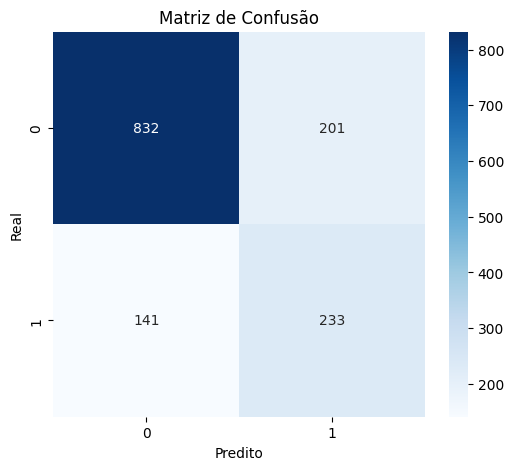

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
with torch.no_grad():
    # 1. Obter previsões (Logits)
    y_logits = model(X_test_t)
    
    # 2. Converter para probabilidade (Sigmoid) e depois para Classe (0 ou 1)
    y_probs = torch.sigmoid(y_logits)
    y_preds = (y_probs > 0.5).float()
    
    # 3. Mover para CPU para usar com Scikit-Learn
    y_preds_np = y_preds.cpu().numpy()
    y_test_np = y_test_t.cpu().numpy()

# Calcular métricas
acc = accuracy_score(y_test_np, y_preds_np)
print(f'Acurácia no Teste: {acc:.2%}')
print("\nRelatório de Classificação:")
print(classification_report(y_test_np, y_preds_np))

# (Opcional) Plotar Matriz de Confusão
cm = confusion_matrix(y_test_np, y_preds_np)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

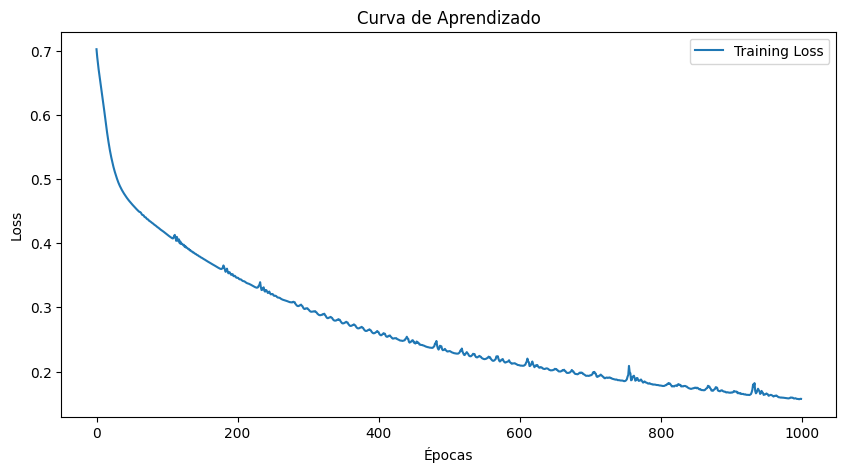

In [10]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.title('Curva de Aprendizado')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

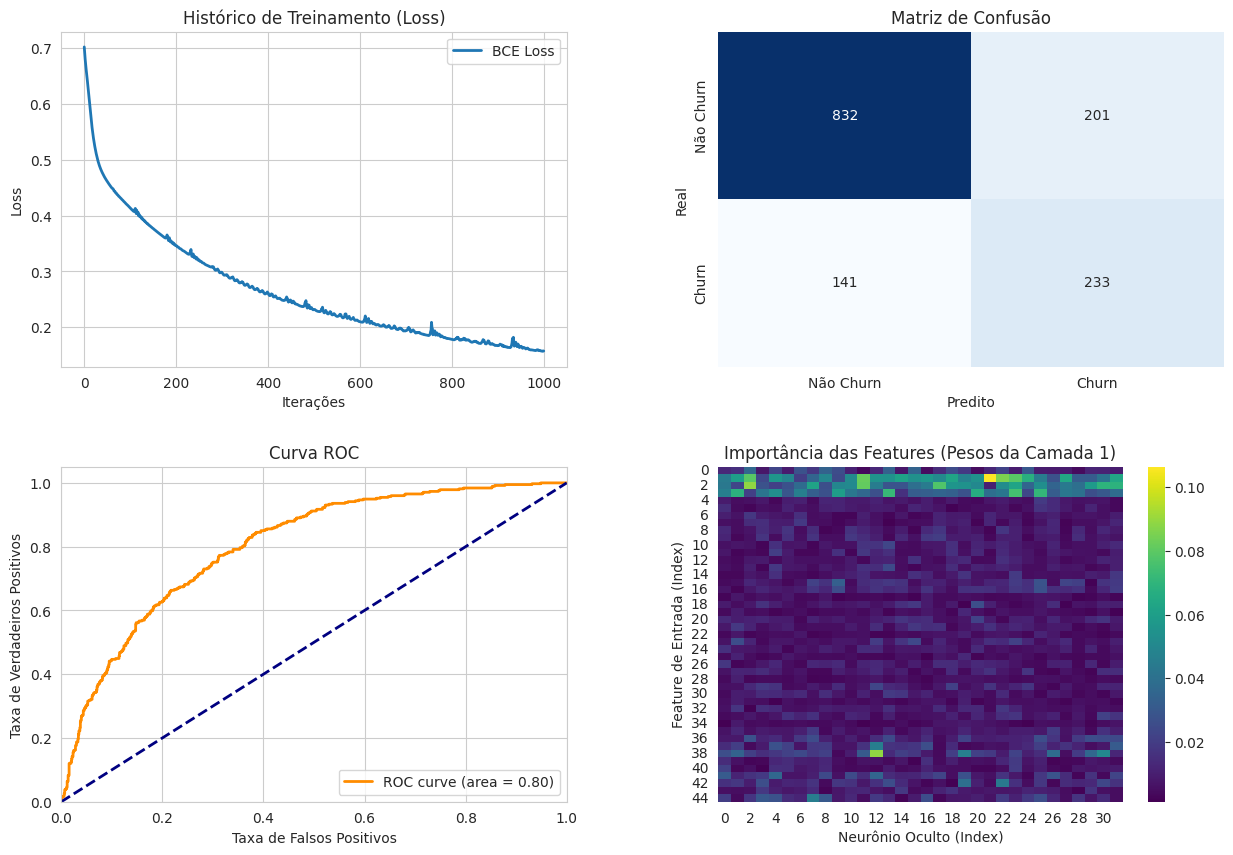

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import torch

def plot_churn_kan_results(model, train_losses, X_test, y_test):
    """
    Script completo para visualizar treinamento, performance e pesos da KAN.
    """
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 10})
    
    # Configurar layout do grid (2 linhas, 2 colunas)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # ------------------------------------------
    # 1. Curva de Loss (Treinamento)
    # ------------------------------------------
    ax1 = axes[0, 0]
    ax1.plot(train_losses, label='BCE Loss', color='tab:blue', linewidth=2)
    ax1.set_title('Histórico de Treinamento (Loss)')
    ax1.set_xlabel('Iterações')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # ------------------------------------------
    # Preparar Previsões
    # ------------------------------------------
    model.eval()
    with torch.no_grad():
        logits = model(X_test)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_true = y_test.cpu().numpy()

    # ------------------------------------------
    # 2. Matriz de Confusão
    # ------------------------------------------
    ax2 = axes[0, 1]
    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=False)
    ax2.set_title('Matriz de Confusão')
    ax2.set_xlabel('Predito')
    ax2.set_ylabel('Real')
    ax2.set_xticklabels(['Não Churn', 'Churn'])
    ax2.set_yticklabels(['Não Churn', 'Churn'])

    # ------------------------------------------
    # 3. Curva ROC
    # ------------------------------------------
    ax3 = axes[1, 0]
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('Taxa de Falsos Positivos')
    ax3.set_ylabel('Taxa de Verdadeiros Positivos')
    ax3.set_title('Curva ROC')
    ax3.legend(loc="lower right")

    # ------------------------------------------
    # 4. Visualização dos Pesos KAN (Feature Importance)
    # ------------------------------------------
    # Tentamos extrair os coeficientes da primeira camada
    # Na maioria das implementações KAN, os pesos são (in_features, out_features, degree)
    # Vamos calcular a norma média desses pesos para ver a "força" da conexão
    ax4 = axes[1, 1]
    try:
        # Acessa os parâmetros da layer1
        # Nota: O nome exato do parâmetro varia, mas geralmente é o primeiro listado
        layer1_weights = list(model.layer1.parameters())[0].data.cpu().numpy()
        
        # Se for 3D (in, out, degree), tiramos a média absoluta para simplificar em 2D
        if len(layer1_weights.shape) == 3:
            # Heatmap: Eixo X = Neurônios Ocultos, Eixo Y = Features de Entrada
            weight_magnitude = np.mean(np.abs(layer1_weights), axis=2)
            
            sns.heatmap(weight_magnitude, cmap='viridis', ax=ax4)
            ax4.set_title('Importância das Features (Pesos da Camada 1)')
            ax4.set_ylabel('Feature de Entrada (Index)')
            ax4.set_xlabel('Neurônio Oculto (Index)')
        else:
            ax4.text(0.5, 0.5, "Formato de pesos não suportado para plot 2D", ha='center')
            
    except Exception as e:
        ax4.text(0.5, 0.5, f"Não foi possível visualizar pesos:\n{str(e)}", ha='center')
        ax4.axis('off')

    plt.show()

# --- Executar o Script ---
# Certifique-se de que train_losses foi preenchido na célula anterior
if 'train_losses' in locals() and len(train_losses) > 0:
    plot_churn_kan_results(model, train_losses, X_test_t, y_test_t)
else:
    print("A variável 'train_losses' está vazia. Rode o treinamento primeiro.")